# CoronaInDeStad.nl Web Crawler

Web crawler for the website coronaindestad.nl

## 1. Retrieve html documents from website

In [1]:
from bs4 import BeautifulSoup
import os
import requests
import sys
import time

In [54]:
# URL = "https://www.coronaindestad.nl/small-poetic-sonic-events-2/" # De collectie
# URL = "https://www.coronaindestad.nl/meervaart-brief-van-floris-van-delft/" # De tentoonstelling
# URL = "https://www.coronaindestad.nl/corona-getuigenissen-verhaal-yurdakul/?h=3364" # Veerkrachtige verhalen uit Amsterdam-West
# URL = "https://www.coronaindestad.nl/van-corona-naar-familie-k/" # Over de tentoonstellin / de gehele collectie
# URL = "https://www.coronaindestad.nl/onderweg-naar-de-datsja/" # texts only
# URL = "https://www.coronaindestad.nl/knuffelen/" # De tentoonstelling
# URL = "https://www.coronaindestad.nl/sound-of-silence-chin-chin-club/" # Corona in de stad
URL = "https://www.coronaindestad.nl/rvdk-ronald-van-der-kemp-army-of-love-surrender-to-a-sustainble-future/"

In [4]:
web_page = requests.get(URL)

In [5]:
def get_next_link(web_page, target_class="next-button"):
    page_links = []
    for a in BeautifulSoup(web_page, "html.parser").select('a'):
        a_class = a.get("class")
        if type(a_class) == list and target_class in a_class:
            page_links.append(a.get("href"))
    return page_links

In [6]:
def get_text(web_page, target_class="large-7"):
    text = []
    for div in BeautifulSoup(web_page, "html.parser").select('div'):
        div_class = div.get("class")
        if type(div_class) == list and target_class in div_class:
            text.append(div.text)
    return text

In [7]:
DATA_DIR = "../coronaindestad.nl/scraped/"

def store_web_page(web_page, file_name):
    out_file = open(file_name, "w")
    print(web_page.content, file=out_file)
    out_file.close()

In [116]:
def fetch_web_page(url):
    time.sleep(1)
    start_time = time.time()
    web_page = requests.get(url)
    fetch_time = int(time.time() - start_time)
    print(f"{fetch_time} {url}")
    date = get_web_page_date(web_page)
    return web_page, date

In [9]:
def make_out_file_name(url):
    return f"{DATA_DIR}{url.split('/')[3]}.html"

In [115]:
def read_file(file_name):
    infile = open(file_name, "r")
    text = ""
    for line in infile:
        text += line
    infile.close()
    date = get_web_page_date(text)
    return text, date

In [118]:
def get_web_page_date(web_page):
    date = ""
    for meta in BeautifulSoup(web_page, "html.parser").select('meta'):
        if "property" in meta.attrs and meta.attrs["property"] == "article:published_time":
             date = meta.attrs["content"]
    return date

In [69]:
def get_web_page_tree(url, URL=URL):
    file_name = make_out_file_name(url)
    if not os.path.isfile(file_name) or url == URL:
        if os.path.isfile(file_name):
            web_page_text, date = read_file(file_name)
        else:
            web_page, date = fetch_web_page(url)
            store_web_page(web_page, file_name)
            web_page_text = web_page.content
        try:
            next_url = get_next_link(web_page_text, target_class="next-button")[0]
            get_web_page_tree(next_url)
        except:
            pass
        try:
            prev_url = get_next_link(web_page_text, target_class="back-button")[0]
            get_web_page_tree(prev_url)
        except:
            pass

In [55]:
get_web_page_tree(URL, URL=URL)

1 https://www.coronaindestad.nl/rvdk-ronald-van-der-kemp-army-of-love-surrender-to-a-sustainble-future/
1 https://www.coronaindestad.nl/de-nieuwe-realiteit/?h=
1 https://www.coronaindestad.nl/wizard-hats-curves-and-the-plunge-in-art-history/?h=
1 https://www.coronaindestad.nl/lezen-in-een-onrustige-tijd/?h=
1 https://www.coronaindestad.nl/opgehokt-onthokt/?h=
1 https://www.coronaindestad.nl/stil-op-de-gracht/?h=
1 https://www.coronaindestad.nl/tramlijn-7/?h=
1 https://www.coronaindestad.nl/the-artist-is-present/?h=
1 https://www.coronaindestad.nl/het-ophalen-van-vuilnis-stagneert/?h=


## 2. Check navigation links in retrieved documents

In [70]:
file_names = os.listdir(DATA_DIR)
counter = 0
for file_name in file_names:
    file_text, date = read_file(DATA_DIR + file_name)
    try:
        next_url = get_next_link(file_text, target_class="next-button")[0]
        get_web_page_tree(next_url, URL=next_url)
    except:
        pass
    try:
        prev_url = get_next_link(file_text, target_class="back-button")[0]
        get_web_page_tree(prev_url, URL=prev_url)
    except:
        pass
    counter += 1
    if counter % 100 == 0:
        print(counter)

100
200
300
400
500
600
700
800
900


In [71]:
len(file_names)

931

## 3. Summarize document data

In [80]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [120]:
def get_months(file_names):
    months = {}
    counter = 0
    for file_name in file_names:
        file_text, date = read_file(DATA_DIR + file_name)
        year = date[0:4]
        month = date[5:7]
        date = year + month
        if date not in months:
            months[date] = 1
        else:
            months[date] += 1
        counter += 1
        if counter % 100 == 0:
            print(counter)
    return months

In [124]:
def plot_months(months):
    x = [ datetime.datetime.strptime(key, "%Y%m") for key in sorted(months.keys()) ]
    y = [ months[key] for key in sorted(months.keys()) ]
    plt.figure(figsize=(6, 3))
    ax = plt.subplot(111)
    ax.bar(x, y, width=31)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%-m/%-y"))
    plt.xlabel("months")
    plt.title("Number of documents per month")
    plt.savefig("coronaindestad.png")
    plt.show()

In [121]:
months = get_months(file_names)

100
200
300
400
500
600
700
800
900


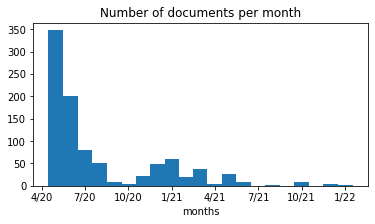

In [125]:
plot_months(months)

In [123]:
{ key: months[key] for key in sorted(months.keys()) }

{'202005': 347,
 '202006': 200,
 '202007': 80,
 '202008': 50,
 '202009': 8,
 '202010': 5,
 '202011': 23,
 '202012': 48,
 '202101': 60,
 '202102': 20,
 '202103': 38,
 '202104': 3,
 '202105': 27,
 '202106': 9,
 '202108': 1,
 '202110': 8,
 '202112': 3,
 '202201': 1}